In [41]:
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
from glob import glob 
import seaborn as sns
import cv2
import os
import itertools
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Load dataset and Summary

In [42]:
images=np.load('images.npy')
label=pd.read_csv('labels.csv')

In [43]:
images.shape

(4750, 128, 128, 3)

In [44]:
label.shape

(4750, 1)

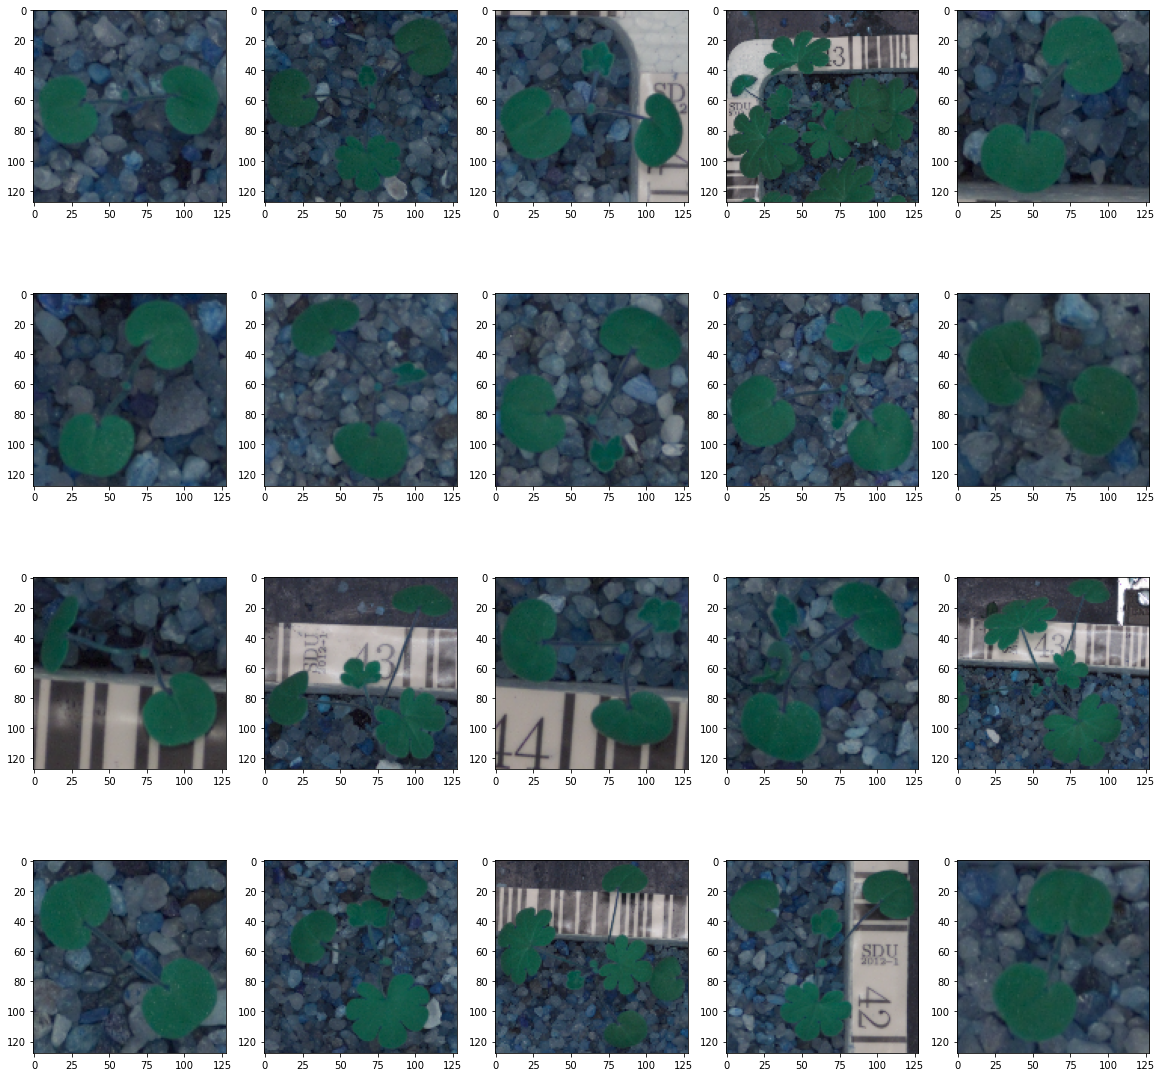

In [45]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5,i+1)
    plt.imshow(images[i])

### Data Preprocessing 

In [46]:
# Applying Gaussian Blurring.
preprocess_image = []

for img in images:
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    preprocess_image.append(blurImg)         
preprocess_image = np.asarray(preprocess_image)

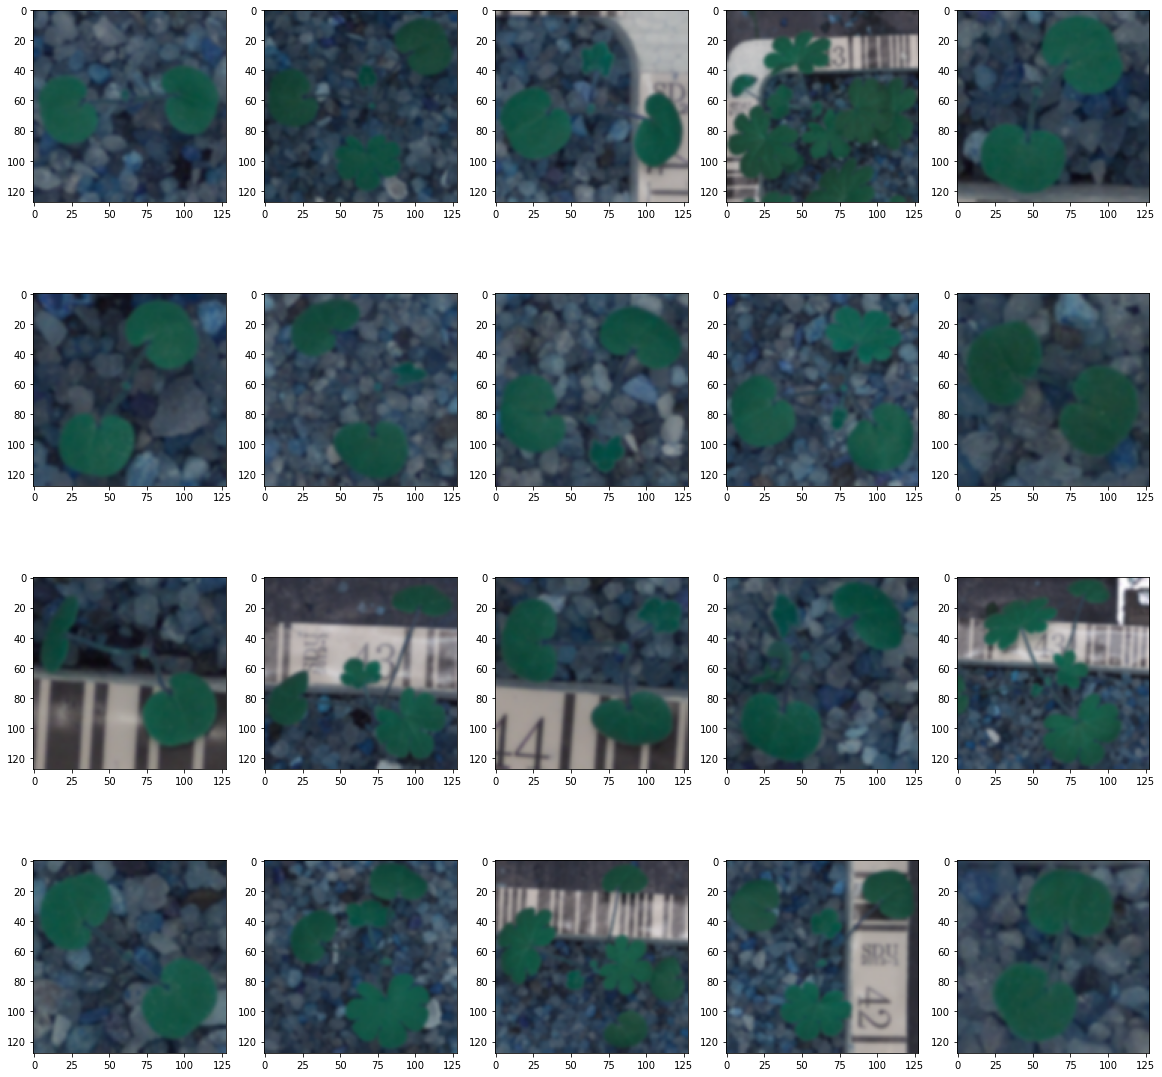

In [47]:
# Preview images after gaussian blurring
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5,i+1)
    plt.imshow(preprocess_image[i])

In [48]:
# Normalization
preprocess_image = preprocess_image / 255

In [49]:
print(f'Shape of the Train array:{preprocess_image.shape}')
print(f'Minimum value in the Train Array:{preprocess_image.min()}')
print(f'Maximum value in the Train Array:{preprocess_image.max()}')

Shape of the Train array:(4750, 128, 128, 3)
Minimum value in the Train Array:0.0
Maximum value in the Train Array:1.0


In [50]:
#Convert labelsto one-hot-vectors.

enc = LabelBinarizer()
processed_lable = enc.fit_transform(label)

In [51]:
processed_lable[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [52]:
#Split the data into train and test and validation set as per the instruction.

X_train, X_test, y_train, y_test = train_test_split(preprocess_image, processed_lable, test_size=0.3, random_state=51)

In [53]:
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=51)

In [54]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_validation.shape)
print(y_validation.shape)

(3325, 128, 128, 3)
(3325, 12)
(712, 128, 128, 3)
(712, 12)
(713, 128, 128, 3)
(713, 12)


#### Compatiblity of input data with Keras model

The input data to CNN is 4D(batch_size, height, width, depth). The output of the CNN is also a 4D array. The output batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding used.
In our case we are training images with 4D model with the shape (3325, 128, 128, 3) for input and the output size which is 128x128. When the model is trained with outputsize as 128x128, then the predicted size is also 128x128.
If we see below, then we can see that output of main_model is (conv2d (Conv2D) (None, 128, 128, 32))
As the output shape is ((None, 128, 128, 32). The first dimension represents the batch size, which is None at the moment because the network does not know the batch size in advance. Once we fit the data, None would be replaced by the batch size we give while fitting the data. So our data is compatible with Keras model.

#### Create the Model:

1. Initialize CNN Classifier
2. Add Convolution layer with 32 kernels of 3x3 shape
3. Add Maxpooling layer of size 2x2
4. Flatten the input array
5. Add dense layer with relu activation function
6. Dropout the probability
7. Add softmax Dense layer as output


In [55]:
batch_size = None

model = Sequential()

# Add convolution layer with 32 filters and 3 kernels
model.add(Conv2D(32, (3,3), batch_input_shape=(batch_size, 128, 128, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

# Add convolution layer with 32 filters and 3 kernels
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

# Flatten the 2D array to 1D array
model.add(Flatten())

# Create fully connected layers with 128 units
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))


# Adding a fully connected layer with 256 neurons
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))

# The final output layer with 12 neurons to predict the categorical classifcation
model.add(Dense(12, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)       

In [58]:
#Optimizer

optimizer = Adam(
                  learning_rate=0.001,
                  name='Adam')
model.compile(optimizer = optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [59]:
model.fit(X_train, y_train, epochs = 40, validation_data = (X_validation,y_validation),batch_size = batch_size)

Epoch 1/40
104/104 [==============================] - 67s 638ms/step - loss: 2.4537 - accuracy: 0.1281 - val_loss: 2.4393 - val_accuracy: 0.1094
Epoch 2/40
104/104 [==============================] - 64s 615ms/step - loss: 2.3294 - accuracy: 0.1786 - val_loss: 2.1250 - val_accuracy: 0.3184
Epoch 3/40
104/104 [==============================] - 62s 595ms/step - loss: 2.0471 - accuracy: 0.3432 - val_loss: 1.7652 - val_accuracy: 0.4109
Epoch 4/40
104/104 [==============================] - 62s 591ms/step - loss: 1.7796 - accuracy: 0.3868 - val_loss: 1.5408 - val_accuracy: 0.4446
Epoch 5/40
104/104 [==============================] - 61s 583ms/step - loss: 1.6458 - accuracy: 0.4307 - val_loss: 1.4600 - val_accuracy: 0.4769
Epoch 6/40
104/104 [==============================] - 60s 581ms/step - loss: 1.5288 - accuracy: 0.4704 - val_loss: 1.2889 - val_accuracy: 0.5540
Epoch 7/40
104/104 [==============================] - 60s 579ms/step - loss: 1.4206 - accuracy: 0.4947 - val_loss: 1.2350 - val_ac

### Evaluate the model 

In [60]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

23/23 [==============================] - 3s 108ms/step - loss: 1.0893 - accuracy: 0.6980
Test loss: 1.09 
 Test accuracy: 0.70
104/104 [==============================] - 12s 114ms/step - loss: 0.1184 - accuracy: 0.9690
Train loss: 0.12 
 Train accuracy: 0.97


**Model is overfitting since training accuracy is 97% and testing accuracy is 70%. Lets try to reduce the epoch**

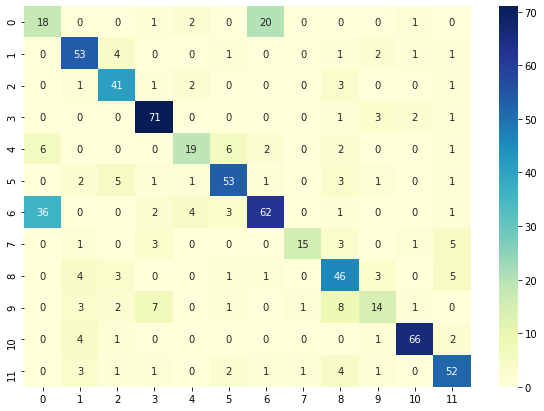

In [61]:
# Predict the values from the validation dataset
Y_predicted = model.predict(X_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_predicted, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validation, axis=1)

conf_mat = confusion_matrix(Y_true, Y_pred_classes)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 12)],
                  columns = [i for i in range(0, 12)])
plt.figure(figsize = (10,7))
plt.ylabel('True label')
plt.xlabel('Predicted label')
sns.heatmap(df_cm, annot=True, fmt='g',cmap="YlGnBu");

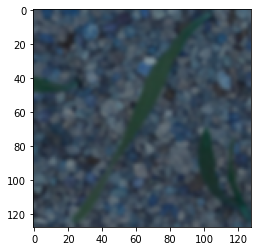

Predicted Label 4
True Label 4


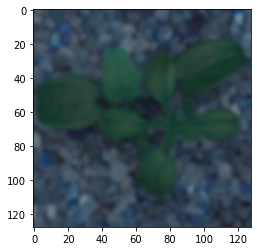

Predicted Label 2
True Label 2


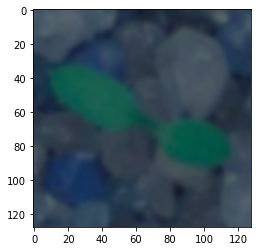

Predicted Label 3
True Label 3


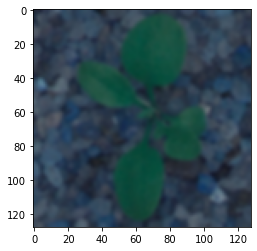

Predicted Label 9
True Label 9


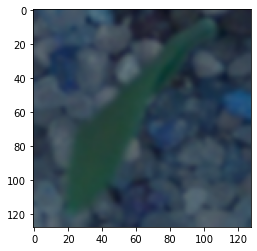

Predicted Label 5
True Label 4


In [62]:
#Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59].

index = [2,3,33,36,59]
for i in index:
    plt.imshow(X_test[i], cmap='gray')
    plt.show()
    print('Predicted Label', np.argmax(model.predict(X_test[i].reshape(1,128,128,3))))
    print('True Label', np.argmax(y_test[i]))